# CIB extraction from SFD


This notebook demonstrates how scattering covariance can be employed to improve the Cosmic Infrared Background (CIB) and galactic dust emission in the Schlegel, Finkbeiner, & Davis (1998; SFD) map separation. The method asserts that anticipated large-scale structure (LSS) statistics, derived from prior research using galaxy catalogs in specific sky regions (Chiang et al. 2023, https://arxiv.org/abs/2306.03926), are known. Using these data, one can compute statistical constraints for the examined sky region and extend these statistics across the entire sky, assuming that the CIB remains consistent globally.

The statistics bases in build using saterring covariance () and express later as $\Phi(x)$ for an image $x$ (Cheng et al., https://doi.org/10.1093/pnasnexus/pgae103). The scattering covariance can also provides correlated information ($\Phi(x,y)$ where $x$ and $y$ are two separated maps). This could be very helpfull to enforce the result to correlate with resolved structure, mainly the large scale taht are above the CIB information while the smaller scale are correlated with the large scale and then the correlation information provide constrains to set the small scales at the proper place.


In [1]:
# install the foscat package

!pip install foscat==3.2.0

  Using cached foscat-3.2.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached healpy-1.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
Using cached foscat-3.2.0-py3-none-any.whl (80 kB)
Using cached healpy-1.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.9 MB)


In [2]:
# call all needed pythin packages

import numpy as np
import os, sys
import matplotlib.pyplot as plt
import healpy as hp
import foscat.scat_cov as sc
import foscat.Synthesis as synthe

## Get the data

The CIB mask and the LSS map from Chiang et al. are available here: https://idv.sinica.edu.tw/ykchiang/CSFD.html. 

In this exemple data has be copy in the *data* directory.

The next cell also define the healpix resolution (nside=256 for quick computation).

In [3]:
nside=256
amp_cib=1.0
norm_spec=None

#get the mask and define the mask with a 4 threshold
m=hp.reorder(hp.ud_grade(hp.read_map('data/cib_mask.fits'),nside),r2n=True)
mask=(m>=4).reshape(1,12*nside**2)

# get lss map 
lss=hp.reorder(hp.ud_grade(hp.read_map('data/lss_intensity.fits'),nside),r2n=True)

# fill lss holes with noise 
fillvalue=np.std(lss[m>=4])
lss[m<2]=np.random.randn(lss[m<2].shape[0])*fillvalue
lss[lss<-1E20]=np.random.randn(lss[lss<-1E20].shape[0])*fillvalue
lss=lss*amp_cib
# read the input data
sfd=hp.reorder(hp.ud_grade(hp.read_map('data/IRAS_100_SFD_T_corrected.fits'),nside),r2n=True)

# get the HI data
HI=hp.reorder(hp.ud_grade(hp.read_map('data/NHI_HPX.fits',4),nside),r2n=True)
HI=1E-20*(HI-np.min(HI))

/tmp/ipykernel_1332/1538419827.py:12: RuntimeWarning: divide by zero encountered in divide
  hp.gnomview(lss/mask[0],rot=rot,reso=reso,cmap='coolwarm',min=-amp,max=amp,nest=True,


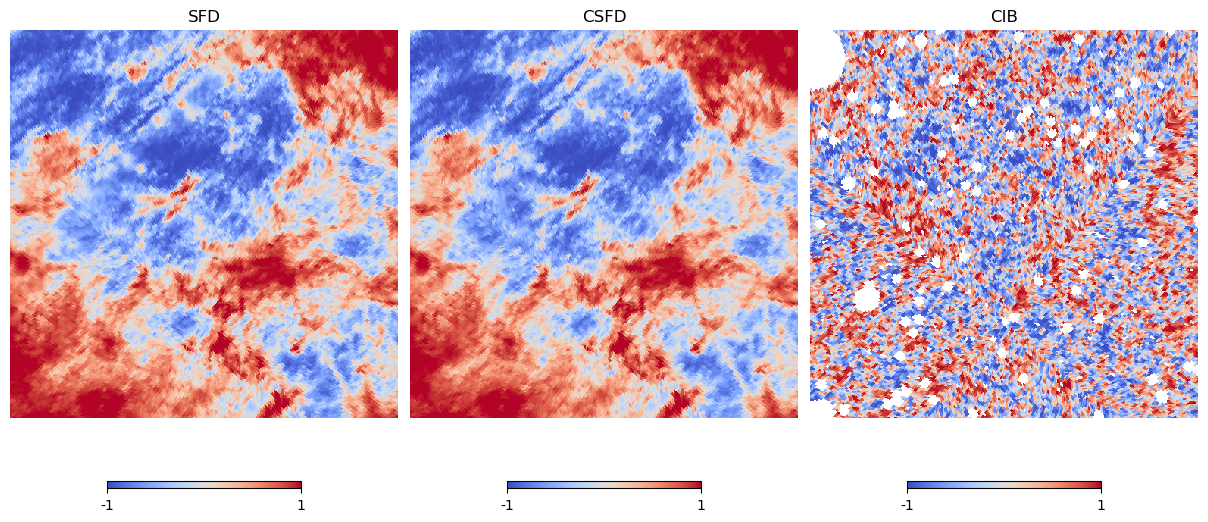

In [20]:
# make a plot
xsize=512
reso=40*60/xsize
off=0.5
amp=1
rot=[-50,-80]
plt.figure(figsize=(12,8))
hp.gnomview(sfd-off,rot=rot,reso=reso,cmap='coolwarm',min=-amp,max=amp,nest=True,
            hold=False,sub=(1,3,1),notext=True,norm='hist',xsize=xsize,title='SFD')
hp.gnomview(sfd-lss-off,rot=rot,reso=reso,cmap='coolwarm',nest=True,
            min=-amp,max=amp,hold=False,sub=(1,3,2),notext=True,norm='hist',xsize=xsize,title='CSFD')
hp.gnomview(lss/mask[0],rot=rot,reso=reso,cmap='coolwarm',min=-amp,max=amp,nest=True,
            hold=False,sub=(1,3,3),notext=True,xsize=xsize,title='CIB',norm='hist')

## call foscat

In [5]:
scat_op=sc.funct(NORIENT=4,          # define the number of wavelet orientation
                KERNELSZ=3,  #KERNELSZ,  # define the kernel size
                JmaxDelta=2,        # The used Jmax is Jmax-JmaxDelta
                mask_norm=True,
                mask_thres=0.7,
                all_type='float32')

print('Use version ',scat_op.__version__)

          START FOSCAT CONFIGURATION


2024-11-16 07:22:08.805456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 07:22:08.805488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 07:22:08.817038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 07:22:08.831370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : /device:GPU:0                          ==
==                                                        ==
==                                                        ==
Init Wave  2
Init Wave  4
Init Wave  8
Init Wave  16
Init Wave  32
Use version  3.2.0


2024-11-16 07:22:11.499202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43713 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6


# generate a population of full sky CIB

In [6]:
def The_loss(x,scat_operator,args):

    ref  = args[0]
    sref = args[1]

    learn=scat_operator.eval(x)

    loss=scat_operator.reduce_distance(learn,ref,sigma=sref)

    return(loss)

In [7]:
ref,sref=scat_op.eval(lss,mask=mask,calc_var=True)
loss=synthe.Loss(The_loss,scat_op,ref,sref)

sy = synthe.Synthesis([loss])

In [8]:
# generate n_cib to compute statistics
try:
    cib_real=amp_cib*np.load('data/cib_real_%d.npy'%(nside))
except:
    n_cib=10
    
    cib_real=np.zeros([n_cib,12*nside**2])
    
    for k in range(n_cib):
        print('Compute CIB instance ',k)
        np.random.seed(1234+k)
        imap=np.random.randn(12*nside**2)*np.std(lss[mask[0]>0])
        
        cib_real[k]=sy.run(imap,
                EVAL_FREQUENCY=100,
                NUM_EPOCHS = 1000).numpy()
    np.save('data/cib_real_%d.npy'%(nside),cib_real)

n_cib=cib_real.shape[0]

/tmp/ipykernel_1332/3692270058.py:2: RuntimeWarning: divide by zero encountered in divide
  hp.mollview(lss/mask[0],cmap='coolwarm',min=-0.1,max=0.1,title='LSS Chiang et al',sub=(2,1,1),hold=False,nest=True,cbar=False)


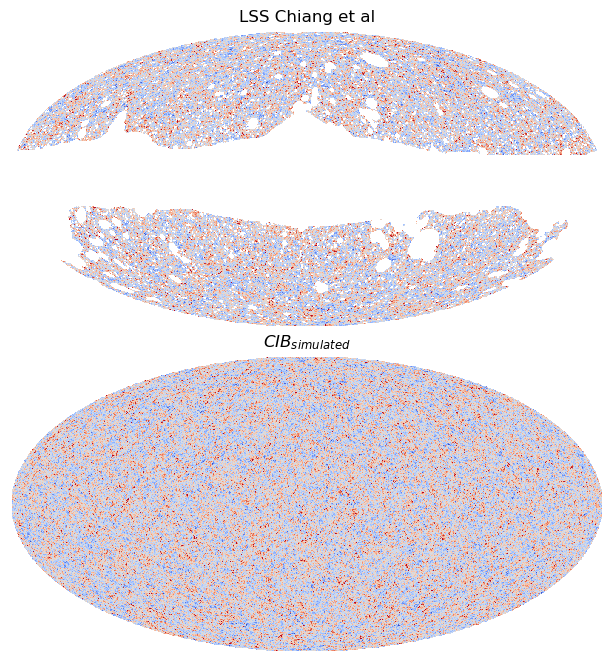

In [30]:
plt.figure(figsize=(6,6.5))
hp.mollview(lss/mask[0],cmap='coolwarm',min=-0.1,max=0.1,title='LSS Chiang et al',sub=(2,1,1),hold=False,nest=True,cbar=False)
hp.mollview(cib_real[0],cmap='coolwarm',min=-0.1,max=0.1,title=r'${CIB}_{simulated}$',sub=(2,1,2),hold=False,nest=True,cbar=False)

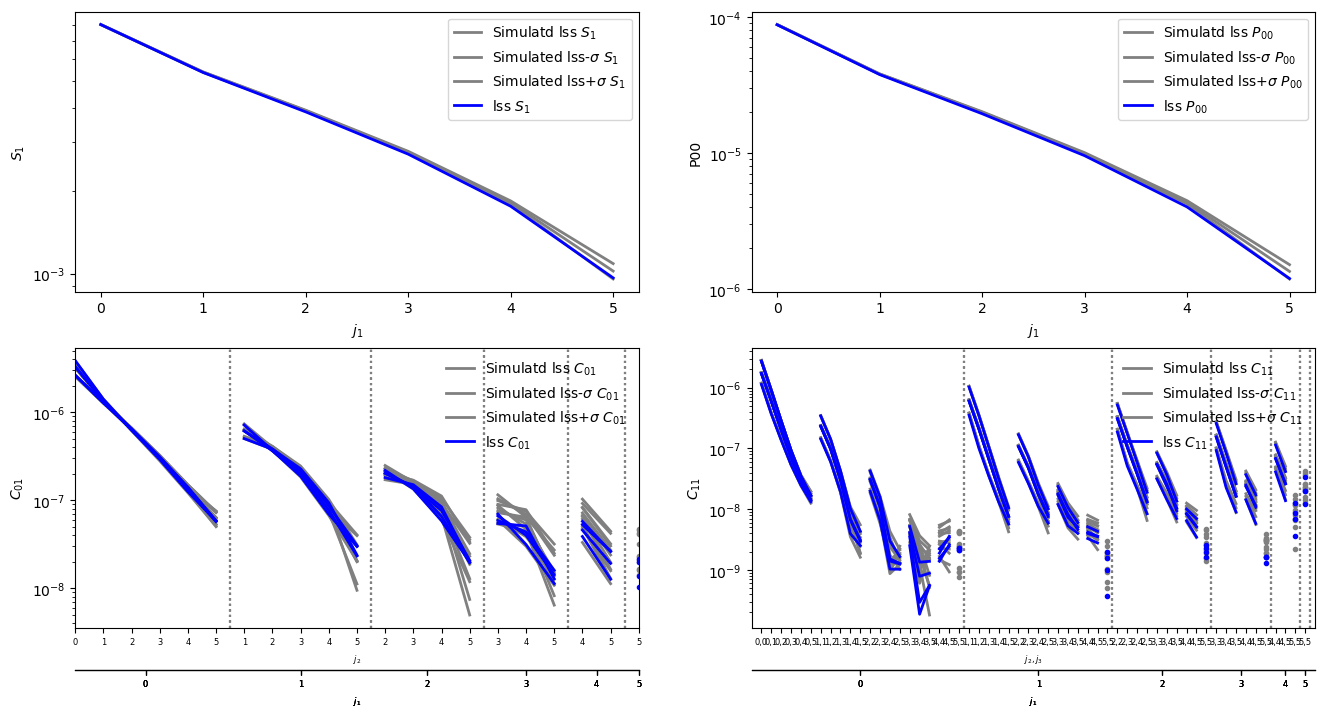

In [9]:
scat_lss=scat_op.eval(lss,mask=mask,norm=norm_spec).iso_mean()
scat_csfd=scat_op.eval(sfd-lss,mask=mask,norm=norm_spec).iso_mean()
scat_cross=scat_op.eval(lss,image2=HI,mask=mask,norm=norm_spec).iso_mean()
scat_HI=scat_op.eval(HI,image2=HI,mask=mask,norm=norm_spec).iso_mean()

scat_simu={}
scat_simu_cross={}
for k in range(n_cib):
    scat_simu[k]=scat_op.eval(cib_real[k],mask=mask,norm=norm_spec).iso_mean()
    scat_simu_cross[k]=scat_op.eval(cib_real[k],image2=HI,mask=mask,norm=norm_spec).iso_mean()

scat_mean,scat_var=scat_op.moments(scat_simu)
scat_mean.plot(color='gray',name='Simulatd lss',lw=2)
(scat_mean+scat_var).plot(color='gray',name=r'Simulated lss-$\sigma$',lw=2,hold=False)
(scat_mean-scat_var).plot(color='gray',name=r'Simulated lss+$\sigma$',lw=2,hold=False)
scat_lss.plot(color='b',name=r'lss',lw=2,hold=False)




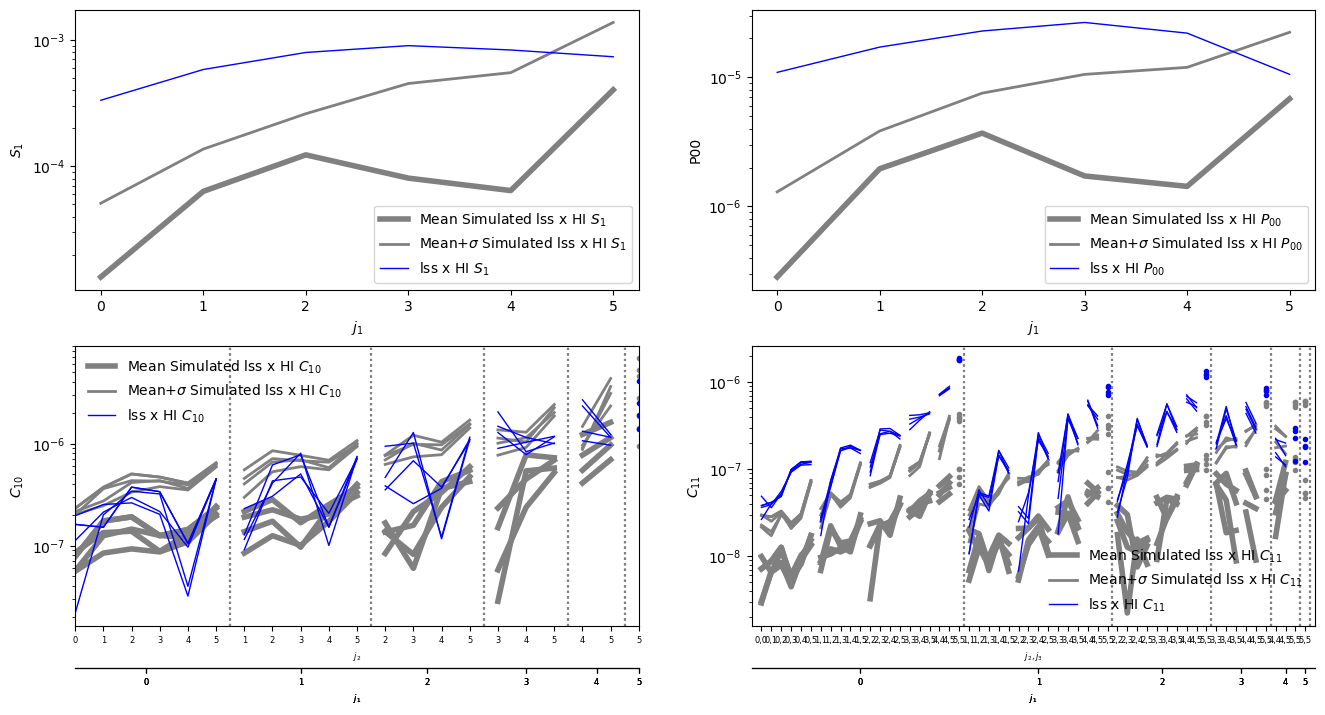

In [10]:

#scat_csfd.plot(color='r',name='sfd',hold=False)
#scat_HI.plot(color='orange',name='HI x HI',hold=False)
scat_mean_cross,scat_var_cross=scat_op.moments(scat_simu_cross)
scat_mean_cross.plot(color='gray',name='Mean Simulated lss x HI',lw=4)
(scat_mean_cross+scat_var_cross).plot(color='gray',name=r'Mean+$\sigma$ Simulated lss x HI',hold=False,lw=2)
scat_cross.plot(color='b',name='lss x HI',hold=False)

### Loss definition

$d$ is the orginal map that is model by $d=D+lss$, where $D$ is the galactic dust emission while $lss$ is the large scale structures observed in microwave, that is usually called the Cosmological Infrared Background (CIB).

The *The_loss_1* function imposes that the residual map has consistent statistics with lss:

$\Phi(d) \approx \Phi(u+c_i)$

The *The_loss_2* function imposes that the residual map has the lss statistics:

$\Phi(d-u) \approx \Phi(c_i)$

The *The_loss_3* function imposes that the residual map is corelated with the input data:

$\Phi(d-u,H_I) \approx \Phi(c_i,H_I)$

The *The_loss_4* function imposes that the residual map is uncorelated with the $H\alpha$ emission:

$\Phi(lss,H_I) \approx \Phi(c_i,H_I)$

In [11]:
#$\Phi(d) \approx \Phi(u+c_i)$
def The_loss_1(x,scat_operator,args):

    ref  = args[0]
    sref = args[1]
    bref = args[2]

    learn=scat_operator.eval(x).flatten()+bref

    loss=scat_operator.reduce_sum(scat_operator.square((learn-ref)/sref))

    return(loss)

#$\Phi(d-u) \approx \Phi(c_i)$
def The_loss_2(x,scat_operator,args):

    ref  = args[0]
    sref = args[1]
    SFD  = args[2]

    learn=scat_operator.eval(SFD-x).flatten()

    loss=scat_operator.reduce_sum(scat_operator.square((learn-ref)/sref))

    return(loss)

#$\Phi(d-u,u) \approx \Phi(c_i,u)$
def The_loss_3(x,scat_operator,args):

    ref  = args[0]
    sref = args[1]
    SFD  = args[2]

    learn=scat_operator.eval(SFD-x,image2=x).flatten()

    loss=scat_operator.reduce_sum(scat_operator.square((learn-ref)/sref))

    return(loss)

#$\Phi(d-u,H_I) \approx \Phi(c_i,H_I)$
def The_loss_4(x,scat_operator,args):

    ref  = args[0]
    sref = args[1]
    HI   = args[2]
    SFD  = args[3]
    mask = args[4]

    learn=scat_operator.eval(SFD-x,image2=HI,mask=mask).flatten()

    loss=300*scat_operator.reduce_sum(scat_operator.square((learn-ref)/sref))

    return(loss)

In [12]:
#$\Phi(d) \approx \Phi(u+c_i)$
ref1=scat_op.eval(sfd).flatten()
bias_stat1=np.zeros([n_cib,ref1.shape[1]],dtype='complex')
for k in range(n_cib):
    bias_stat1[k]=scat_op.eval(cib_real[k]+sfd).flatten()
bref1=np.mean(bias_stat1-ref1,0)
sref1=np.std(bias_stat1-ref1,0)+0j
loss1=synthe.Loss(The_loss_1,scat_op,ref1,sref1,bref1)

#$\Phi(d-u) \approx \Phi(c_i)$
ref2=scat_op.eval(cib_real).flatten()
mref2=np.mean(ref2,0)
sref2=np.std(ref2,0)+0j
loss2=synthe.Loss(The_loss_2,scat_op,mref2,sref2,sfd)

#$\Phi(d-u,u) \approx \Phi(c_i,u)$
ref3=scat_op.eval(cib_real[0],image2=sfd-lss,mask=mask).flatten()
bias_stat3=np.zeros([n_cib,ref3.shape[1]],dtype='complex')
for k in range(n_cib):
    bias_stat3[k]=scat_op.eval(cib_real[k],image2=sfd-lss,mask=mask).flatten()
ref3=scat_op.eval(lss,image2=sfd-lss,mask=mask).flatten()
bref3=np.mean(bias_stat3,0)
sref3=np.std(bias_stat3,0)+0j

loss3=synthe.Loss(The_loss_3,scat_op,ref3,sref3,sfd)

mask_cib_HI=np.ones([2,12*nside**2])
mask_cib_HI[1]=mask

#$\Phi(d-u,HI) \approx \Phi(c_i,H_I)$
ref4=scat_op.eval(sfd,image2=HI,mask=mask_cib_HI).flatten()
bias_stat4=np.zeros([n_cib,ref4.shape[1]],dtype='complex')
for k in range(n_cib):
    bias_stat4[k]=scat_op.eval(cib_real[k],image2=HI,mask=mask_cib_HI).flatten()
    
bref4=np.mean(bias_stat4,0)
sref4=np.std(bias_stat4,0)+0j

loss4=synthe.Loss(The_loss_4,scat_op,bref4,sref4,HI,sfd,mask_cib_HI)
#sy = synthe.Synthesis([loss1,loss2,loss3,loss4])
sy = synthe.Synthesis([loss2,loss4])

In [13]:
imap=sfd-lss #+1E-4*np.random.randn(12*nside**2)
#=================================================================================
# RUN ON SYNTHESIS
#=================================================================================
omap=sy.run(imap,
        EVAL_FREQUENCY=100,
        NUM_EPOCHS = 3000).numpy()

Total number of loss  2
 Run [PROC=0000] on GPU /device:GPU:0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 Run [PROC=0000] on GPU /device:GPU:0
Itt      0 L=  6.25e+09 (  1.25e+10   2.86e+07 ) 47.961s 
Itt    100 L=  2.61e+06 (  3.41e+06   1.81e+06 ) 30.190s 
Itt    200 L=  9.14e+05 (   9.5e+05   8.78

/tmp/ipykernel_1332/1921843775.py:4: RuntimeWarning: divide by zero encountered in divide
  hp.gnomview(lss/mask[0],nest=True,cmap='jet',rot=[0,90],reso=reso,
/tmp/ipykernel_1332/1921843775.py:8: RuntimeWarning: divide by zero encountered in divide
  hp.gnomview((lss-(sfd-omap))/mask[0],nest=True,cmap='jet',rot=[0,90],reso=reso,


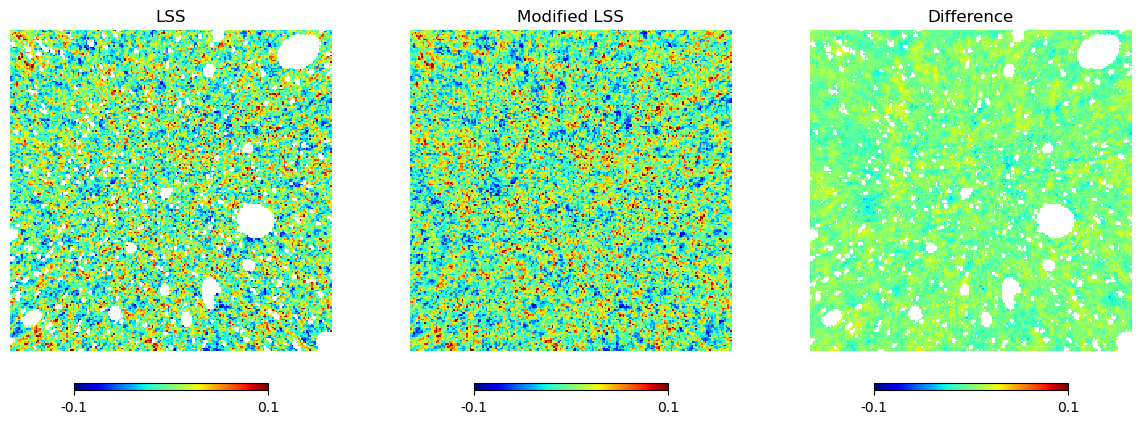

In [14]:
reso=30
rot=[-50,80]
plt.figure(figsize=(12,4))
hp.gnomview(lss/mask[0],nest=True,cmap='jet',rot=[0,90],reso=reso,
            min=-0.1,max=0.1,hold=False,sub=(1,3,1),notext=True,title='LSS')
hp.gnomview(sfd-omap,nest=True,cmap='jet',rot=[0,90],reso=reso,
            min=-0.1,max=0.1,hold=False,sub=(1,3,2),notext=True,title='Modified LSS')
hp.gnomview((lss-(sfd-omap))/mask[0],nest=True,cmap='jet',rot=[0,90],reso=reso,
            min=-0.1,max=0.1,hold=False,sub=(1,3,3),notext=True,title='Difference')

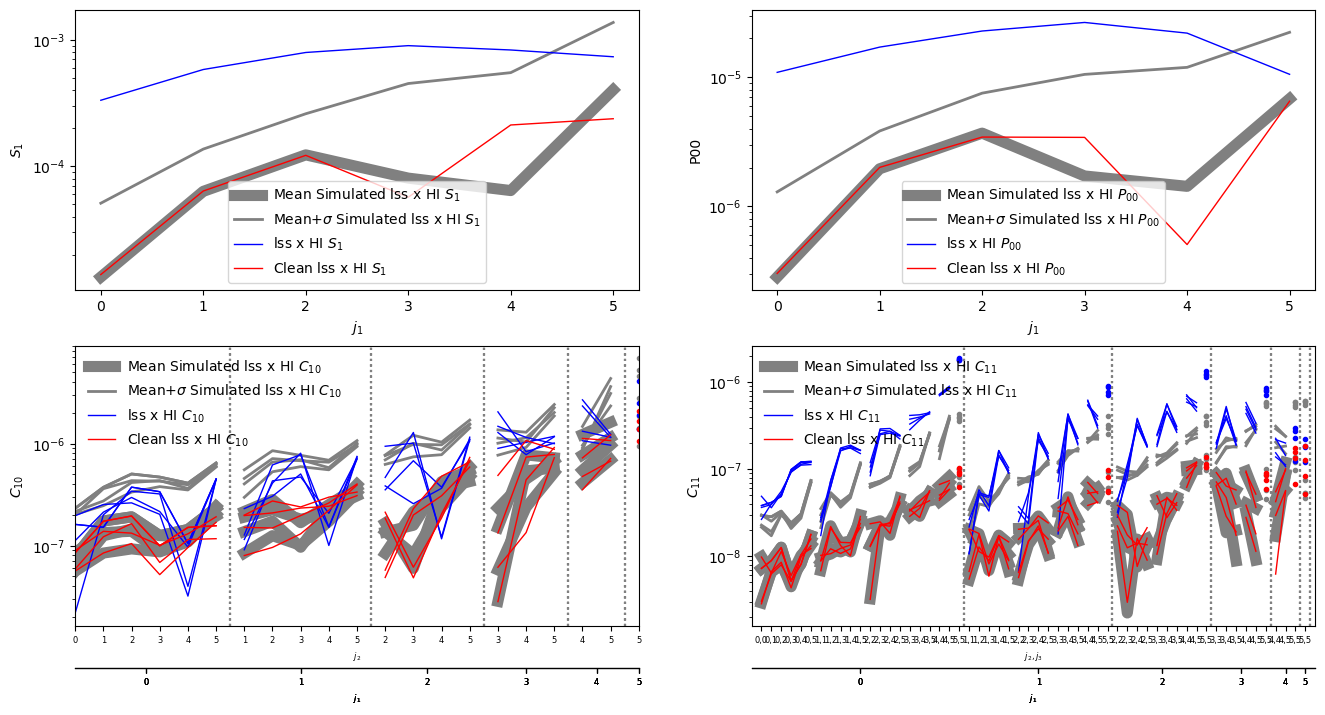

In [15]:
scat_clean=scat_op.eval(sfd-omap,image2=HI,mask=mask,norm=norm_spec).iso_mean()
scat_mean_cross.plot(color='gray',name='Mean Simulated lss x HI',lw=8)
(scat_mean_cross+scat_var_cross).plot(color='gray',name=r'Mean+$\sigma$ Simulated lss x HI',hold=False,lw=2)
scat_cross.plot(color='b',name='lss x HI',hold=False)
scat_clean.plot(color='r',name='Clean lss x HI',hold=False)

In [16]:
print(np.std((lss+(sfd-omap))[mask[0]==1])/(np.sqrt(2)*np.std(lss[mask[0]==1])))
print(np.std((lss-(sfd-omap))[mask[0]==1])/(np.sqrt(2)*np.std(lss[mask[0]==1])))

1.4057470315534946
0.23501840617510045


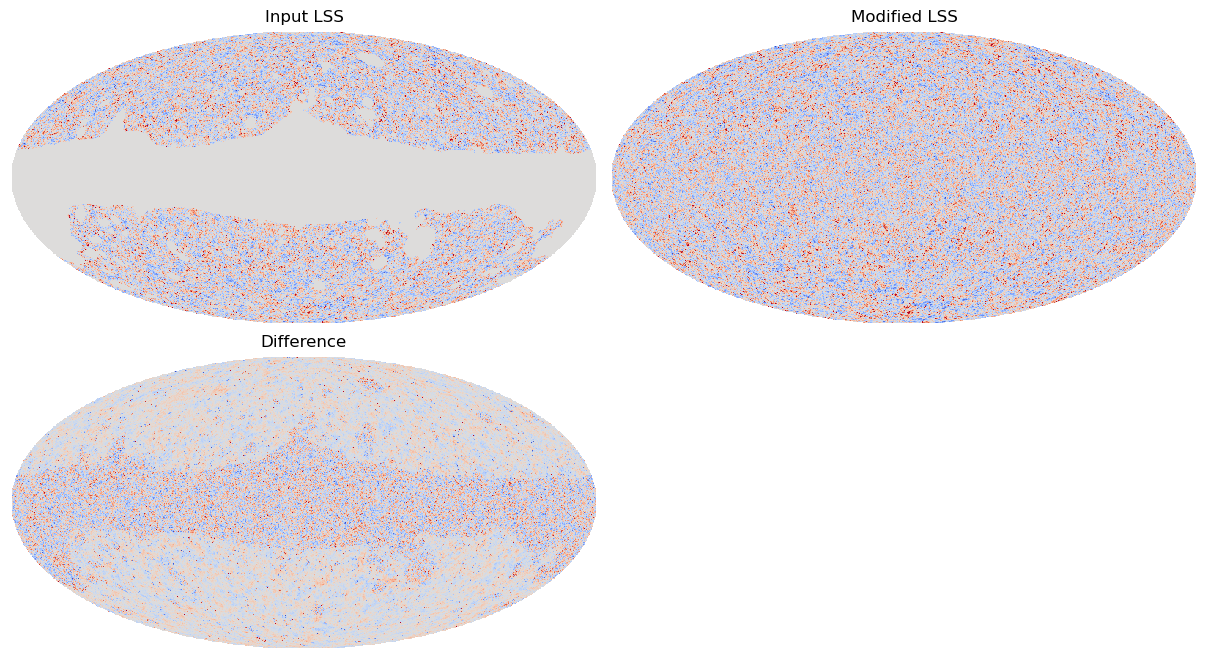

In [31]:
plt.figure(figsize=(12,6.5))
hp.mollview(lss*mask[0],nest=True,cmap='coolwarm',min=-0.1,max=0.1,hold=False,sub=(2,2,1),cbar=False,title='Input LSS')
hp.mollview(sfd-omap,nest=True,cmap='coolwarm',min=-0.1,max=0.1,hold=False,sub=(2,2,2),cbar=False,title='Modified LSS')
hp.mollview((sfd-omap)-lss*mask[0],nest=True,cmap='coolwarm',min=-0.1,max=0.1,hold=False,sub=(2,2,3),cbar=False,title='Difference')

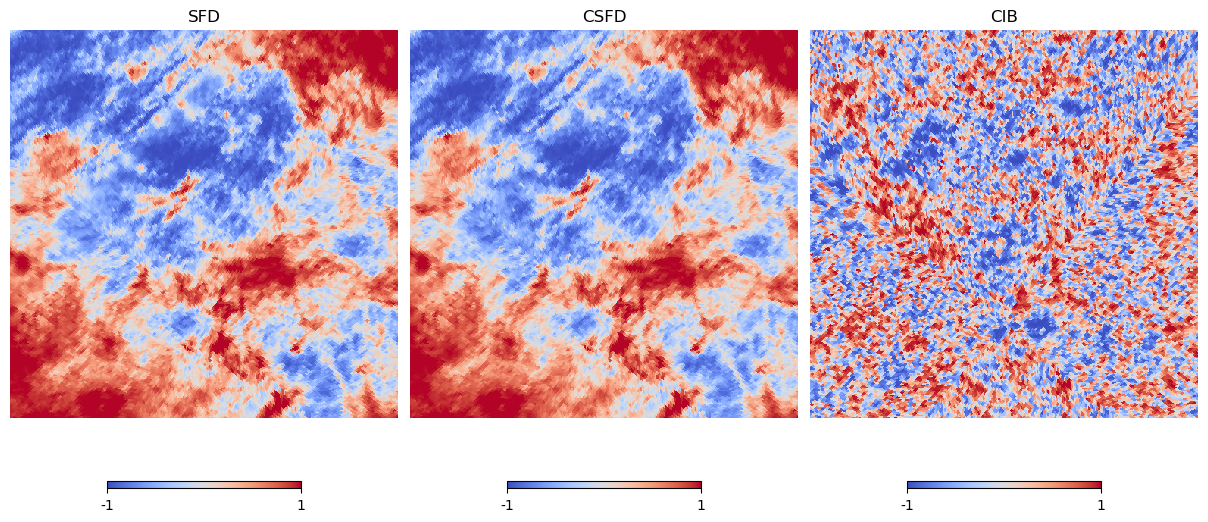

In [18]:
xsize=512
reso=40*60/xsize
off=0.5
amp=1
rot=[-50,-80]
plt.figure(figsize=(12,8))
hp.gnomview(sfd-off,rot=rot,reso=reso,cmap='coolwarm',min=-amp,max=amp,nest=True,
            hold=False,sub=(1,3,1),notext=True,norm='hist',xsize=xsize,title='SFD')
hp.gnomview(omap-off,rot=rot,reso=reso,cmap='coolwarm',nest=True,
            min=-amp,max=amp,hold=False,sub=(1,3,2),notext=True,norm='hist',xsize=xsize,title='CSFD')
hp.gnomview(sfd-omap,rot=rot,reso=reso,cmap='coolwarm',min=-amp,max=amp,nest=True,
            hold=False,sub=(1,3,3),notext=True,xsize=xsize,title='CIB',norm='hist')

0.09999965338982242


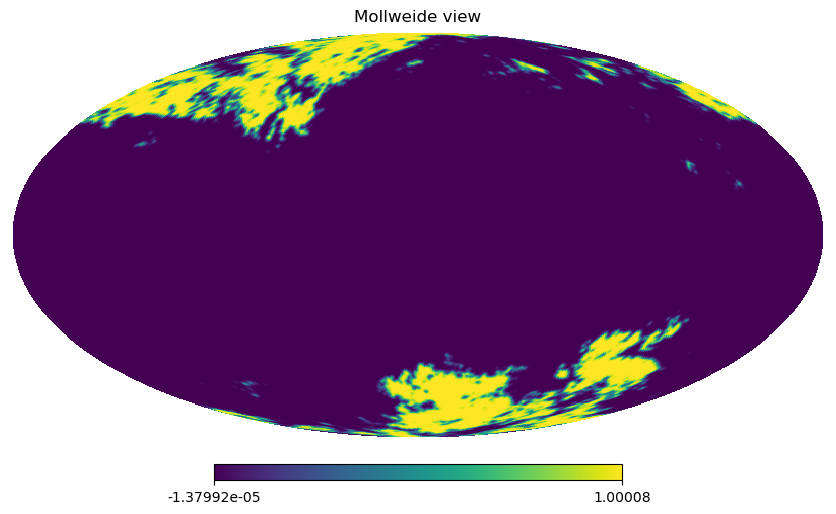

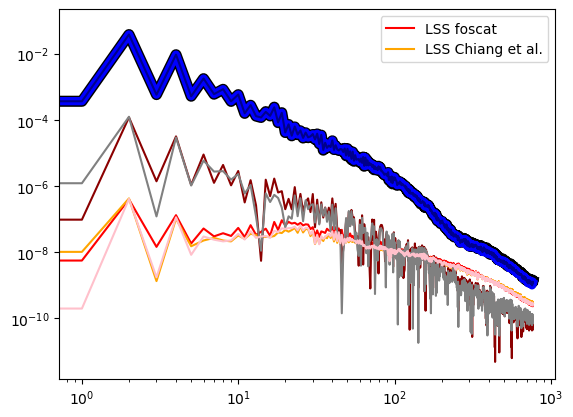

In [19]:
imm=np.argsort(sfd)
mm=hp.smoothing(sfd<sfd[imm[int(12*nside*nside*0.1)]],1/180.*np.pi,nest=True)
hp.mollview(mm,nest=True)
print(np.mean(mm))
cl1=hp.anafast(hp.reorder(mm*sfd-np.median(mm*sfd),n2r=True))
cl2=hp.anafast(hp.reorder(mm*(sfd-lss)-np.median(mm*(sfd-lss)),n2r=True))
cl3=hp.anafast(hp.reorder(mm*(sfd-omap)-np.median(mm*(sfd-omap)),n2r=True))
cl4=hp.anafast(hp.reorder(mm*(lss)-np.median(mm*(lss)),n2r=True))
cl5=hp.anafast(hp.reorder(mm*(omap)-np.median(mm*omap),n2r=True))
clx=hp.anafast(hp.reorder(mm*(sfd-omap)-np.median(mm*(sfd-omap)),n2r=True),map2=hp.reorder(mm*(omap)-np.median(mm*(omap)),n2r=True))
cld=hp.anafast(hp.reorder(mm*(lss)-np.median(mm*(lss)),n2r=True),map2=hp.reorder(mm*(sfd-lss)-np.median(mm*(sfd-lss)),n2r=True))
clx2=hp.anafast(hp.reorder(mm*(sfd-omap)-np.median(mm*(sfd-omap)),n2r=True),
                map2=hp.reorder(mm*(lss)-np.median(mm*(lss)),n2r=True))
plt.figure()
plt.plot(cl1,color='black',lw=8)
plt.plot(cl2,color='b',lw=6)
plt.plot(cl3,color='r',label='LSS foscat')
plt.plot(cl4,color='orange',label='LSS Chiang et al.')
plt.plot(cl5,color='darkblue')
plt.plot(abs(clx),color='darkred')
plt.plot(abs(cld),color='gray')
plt.plot(abs(clx2),color='pink')
plt.xscale('log')
plt.yscale('log')
plt.legend()